# Analyzing Hotel Ratings on Tripadvisor

In this homework, we will analyze the data we scraped in Part 1 by fitting a regression model on the data.

** Task 1 (20 pts) **

Now, we will use regression to analyze this information. First, we will fit a linear regression model that predicts the average rating.

For example, the average rating of a hotel is calculated as follows:

![Information to be scraped](traveler_ratings.png)

$$ \text{AVG_SCORE} = \frac{1*15 + 2*21 + 3*55 + 4*228 + 5*1271}{1590}$$

Use the model to analyze the important factors that decide the $\text{AVG_SCORE}$.

                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     132.3
Date:                Tue, 15 Nov 2016   Prob (F-statistic):           3.68e-37
Time:                        21:32:08   Log-Likelihood:                 51.426
No. Observations:                  80   AIC:                            -88.85
Df Residuals:                      73   BIC:                            -72.18
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -0.1725      0.210     -0.820

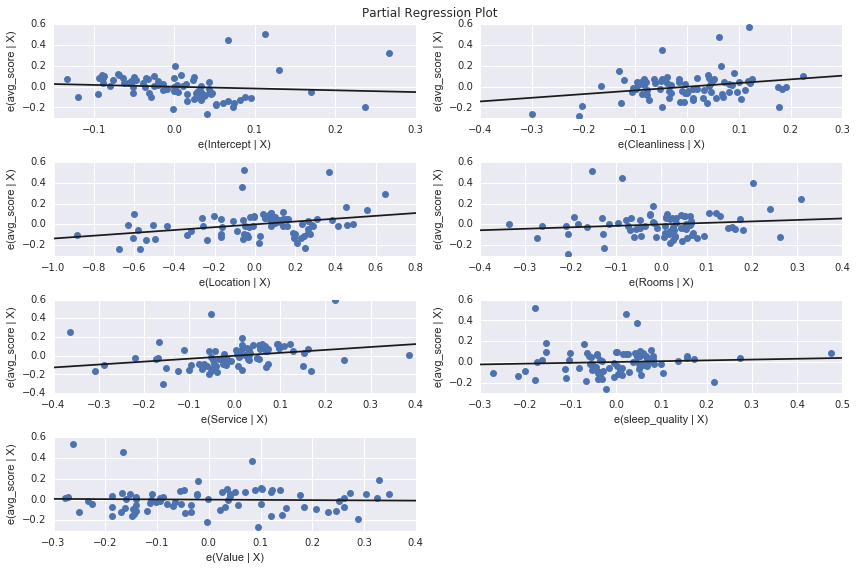

In [41]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

#reading in csv to create dataframe
df = pd.read_csv('traverler_ratings_changed.csv')

hotels = list(df.hotel_name.unique())

def remove_comma(s):
    s = s.replace(',','')
    return s

# get the avg_score of hotel
def get_avg(l):
    e,g,a,p,t = l
    top = (5*e)+(4*g)+(3*a)+(2*p)+t
    avg = top/sum(l)
    return(avg)

# keeps tracks of all hotels and their avgs
hotel_avgs_l = []

# parsing
for h in hotels:
    excel = 0
    
    # getting rows for hotel
    h_df = df.loc[df['hotel_name'] == h]
    # getting rating scores converting them to ints
    score = list(h_df['count'])
    score_stripped = [int(remove_comma(s)) for s in score]
    
    # checking if hotel is excellent or not
    five_percent = score_stripped[0]/sum(score_stripped)
    if (five_percent >= .6):
        excel = 1
    
    # getting avg
    h_avg_rating = get_avg(score_stripped)
    hotel_avgs_l.append({'hotel_name': h, 'avg_score': h_avg_rating, 'excellent': excel})

hotel_avgs_df = pd.DataFrame(hotel_avgs_l)

# keeps track of attributes and their top and bottom used in calculating avg_score (of each rating for a hotel)
hotel_attrib = {} # {hotel: {attrib1: [top, bottom], attrib2: [top, bottom], attrib3: ...}, {hotel: {...}}}

# parsing data
with open('attribute-ratings-summary.dat','r') as f:
    for l in f:
        l_split = l.split(':')
        name = l_split[0]
        attrib = l_split[1]
        score = l_split[2]
        count = int(l_split[3].replace('\n', ''))
        num = int(score)*count
        
        # check if hotel name is in dict
        if name in hotel_attrib:
            val = hotel_attrib[name] # val = {rating: [score,count]}
            if attrib in val:
                val[attrib][0]+=num # add up top for each rating of a hotel
                val[attrib][1]+=count # add up bottom
            else:
                hotel_attrib[name][attrib] = [num,count] 
        else:
            # if hotel name not in dict create new entry in dict of the form 'hotel_name': {'attribute': [top, bottom]}
            hotel_attrib[name] = {attrib:[num,count]} 
            

# divide top by bottom for avg score
def divide(l):
    return (l[0]/l[1])

# keeps track of all the hotels and their avg_score for each attribute
hotel_attrib_avgs = {} # {hotel: {attrib1: avg_score, attrib2: avg_score, attrib3: ...}, {hotel: {...}}}

for hotel, attrib in hotel_attrib.items():
    attrib_l = list(attrib.keys()) # list of attributes
    avg_scores = {a: divide(attrib[a]) for a in attrib_l} # calculates avg_score for attrib in attribute_l
    hotel_attrib_avgs[hotel] = avg_scores

# df version of hotel_attrib_avgs
attrib_avgs_df = pd.DataFrame(hotel_attrib_avgs)
attrib_avgs_df = attrib_avgs_df.transpose()
attrib_avgs_df['hotel_name'] = attrib_avgs_df.index
attrib_avgs_df = attrib_avgs_df.reset_index() 
attrib_avgs_df.drop("index", axis=1, inplace=True)
merged = pd.merge(attrib_avgs_df, hotel_avgs_df, on='hotel_name') # getting the hotel avg_SCORE
merged = merged.rename(index=str, columns={"Sleep Quality": "sleep_quality"})


# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('avg_score ~ Cleanliness + Location + Rooms + Service + sleep_quality + Value', data=merged).fit()

# Inspect the results
print(results.summary())

# plot the results
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results, fig=fig)
plt.show()

Looking at the OLS regression results, the coefficients show that relative to other attributes, the independent variables  cleanliness and service have a stronger positive influence on the dependent variable avg_SCORE for a hotel.  The coefficient indicates that for every additional degree in avg_SCORE you can expect cleanliness and service to increase by an average of 0.31 and 0.35 respectively.  Sleep quality has a coefficient much closer to 0 -- its fitted line for its partial regression (given the effect of the other independent variables in the model) though in the positive direction is much flatter than the rest. This suggests that while it has a small positive affect on the avg_SCORE for a hotel, the expected value for avg_SCORE would change a relatively little positively as you go up the line.  The variable value also has a flattened fitted line but in the negative direction.

-------

** Task 3 (30 pts) **

Finally, we will use logistic regression to decide if a hotel is _excellent_ or not. We classify a hotel as _excellent_ if more than **60%** of its ratings are 5 stars. This is a binary attribute on which we can fit a logistic regression model. As before, use the model to analyze the data.

Optimization terminated successfully.
         Current function value: 0.437264
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              excellent   No. Observations:                   80
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            5
Date:                Tue, 15 Nov 2016   Pseudo R-squ.:                  0.3066
Time:                        21:53:05   Log-Likelihood:                -34.981
converged:                       True   LL-Null:                       -50.446
                                        LLR p-value:                 9.667e-06
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Cleanliness     -16.1839      4.629     -3.496      0.000       -25.258    -7.110
Location         -0.

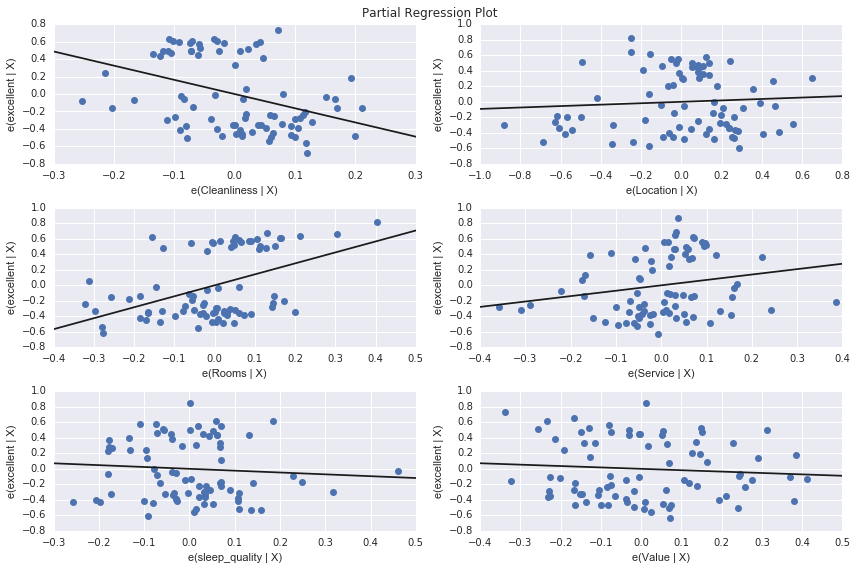

In [47]:
train_cols = merged.columns[:6]
logit = sm.Logit(merged['excellent'], merged[train_cols])
 
# fit the model
result = logit.fit() 
print(result.summary())

# plot the results
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()


It is important to interpret multiple regression coefficients by considering what happens when the other variables are held constant.  The partial regression plots allow for us to analyze the the relationship of the dependent variable (if a hotel is excellent or not) and independent variables (e.g. cleanliness) conditional on the other independent variables (e.g. location).  Here the plots show clear boundary lines. A negative coefficient for cleanliness, value, location, and sleep quality have odds < 1, implying odds of the event -- a hotel being excellent -- occurring are lower than the baseline. Conversely, a positive coefficient for rooms and service have odds > 1, implying increased odds of observing event relative to baseline.

-------